In [112]:
%reload_ext autoreload
%autoreload 2
import pyxdf
import os
import numpy as np
from scipy import stats
from pathlib import Path
import sys
from datetime import datetime
import pandas as pd
from hampel import hampel
import seaborn
import matplotlib.pyplot as plt
from tueplots import axes, bundles

# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 200,"figure.facecolor":"w"})
bundles.beamer_moml()

from utilities.utl import find_lsl_stream, find_nearest, fill_nan, get_channel_labels_ppl_xdf
from utilities.pupil_prep import *
from utilities.SingleSubjectData import SubjectData, Epochs



In [110]:
# (import) helper functions
dir_script = Path("__file__").parent.absolute()
dir_rawdata = Path.joinpath(dir_script.parent.absolute(), "04_data","00_raw")
dir_plots = Path.joinpath(dir_script.parent.absolute(),"06_plots","01_single_trial")
print(dir_script)

c:\Users\User\Desktop\kiel\tremor_feedback_jw\05_scripts


In [5]:
f_list = os.listdir(dir_rawdata)
str_match = 'archer'
fnms = [s for s in f_list if str_match in s]
print([f.split('_')[0] for f in fnms])

['c300', 'c301', 'c302', 'c303', 'c304', 'c305', 'c306', 'c307', 'c308', 'c309', 'c310', 'p200', 'p201', 'p202', 'p203', 'p204', 'p205', 'p206', 'p207', 'p208', 'p209', 'p210', 'p211', 'p212', 'p213', 'p214', 'p215']


Max force is 5598 something
Max force is 8067 something


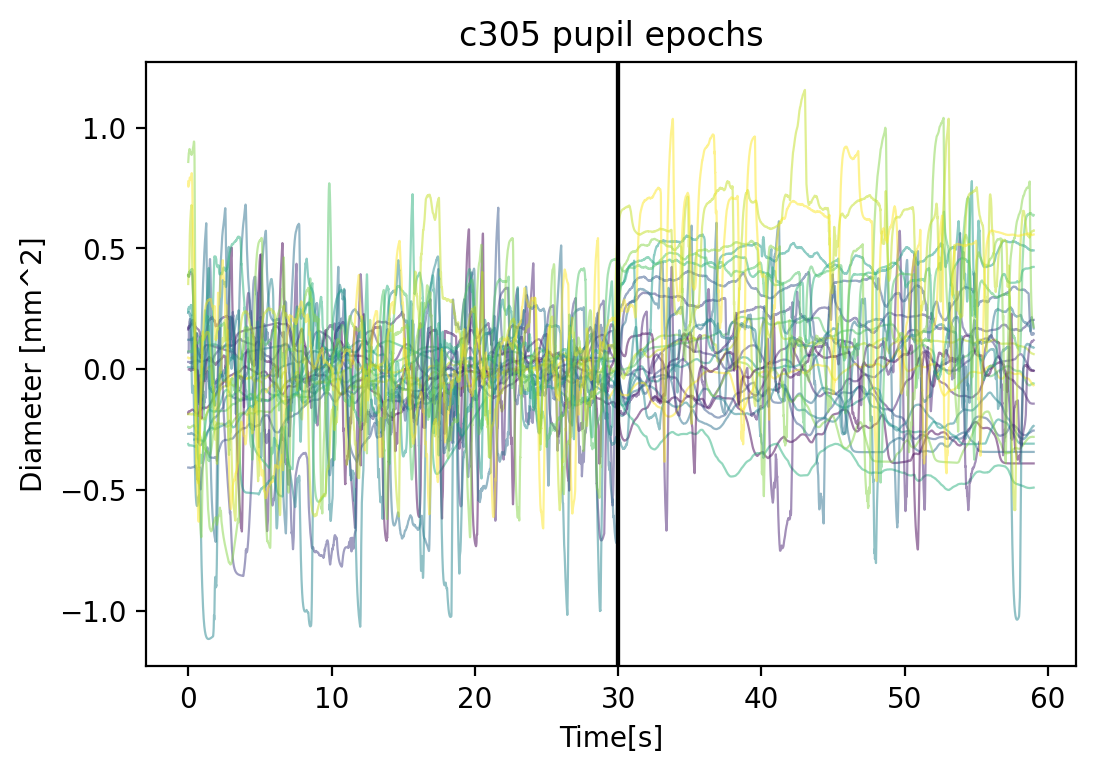

In [114]:
tmp_fnms = fnms[4:6]
n_trial = []
per_bad_samples = []
con_view_ang = []
con_feedback = []
for f in tmp_fnms:
    sub = SubjectData()
    sub.load_data(dir_rawdata,f)

    # extract ppl chn names
    ch_info = sub.eye["info"]["desc"][0]["channels"][0]
    nms_ppl = []
    for i,ch in enumerate(ch_info["channel"]):
        nms_ppl.append(ch_info["channel"][i].get('label')[0])

    # info per epoch
    con_view_ang.extend(eps.events["value"][eps.events["value"].str.contains('sfb') ].str.split('_').str[3].astype(float).round(2))
    con_feedback.extend(eps.events["value"][eps.events["value"].str.contains('epoch') ].str.split('_').str[1])
    n_trial = []
    per_bad_samples = []

    # epoch data
    eps = Epochs(sub,sub.eye["time_series"],times=sub.eye["time_stamps"], events=sub.mrk, srate = sub.srate_ppl)
    idx_exp_start   = eps.events[eps.events["value"].str.match('block1')].index[0]
    eps.epoch('end_trial', idx_start=idx_exp_start,tmin=-60,tmax=0)
    eps.data[eps.data == 0] = np.nan

    # prep pupil data
    ch_oi = ['confidence', 'diameter1_3d']
    idx_ch_oi = [nms_ppl.index(key) for key in ch_oi]   

    # set params for epoch processing and plotting
    cfg_pupil_plot_colors = plt.cm.viridis(np.linspace(0,1,eps.data.shape[2]))
    cfg_bl_times = [20,28]
    cfg_bl_times.sort()

    # prep single trial pupil data
    for i in range(eps.data.shape[2]):

        ep = eps.data[idx_ch_oi,:,i]
        ep = pd.DataFrame(ep.T)
        ep.columns = [ch_oi]
        ep = ep.interpolate(method='linear',axis='rows')

        lower_thresh = ep["diameter1_3d"].median(axis=0)-ep["diameter1_3d"].std(axis=0)*1.5
        upper_thresh = ep["diameter1_3d"].median(axis=0)+ep["diameter1_3d"].std(axis=0)*1.5

        idx_bad_samples = np.logical_or(ep.diameter1_3d < lower_thresh,ep.diameter1_3d > upper_thresh)
        per_bad_samples.append(idx_bad_samples.sum() / len(idx_bad_samples))
        ep["diameter1_3d"] = np.where(idx_bad_samples,np.nan,ep.diameter1_3d)
        
        ep = ep.interpolate(method='linear',axis='rows')
        ep["diameter1_3d"] = hampel(ep["diameter1_3d"].squeeze(), window_size=60, n=1, imputation=True).ewm(span = 60).mean()
        ep["diameter1_3d"].ewm(span = 60).mean()

        # do baseline correction
        bl_diam = ep["diameter1_3d"][np.logical_and(eps.times > cfg_bl_times[0],eps.times < cfg_bl_times[1])].mean()
        ep["diameter1_3d"] = ep["diameter1_3d"] - bl_diam

        plt.plot(eps.times,ep["diameter1_3d"].to_numpy(),color=cfg_pupil_plot_colors[i],linewidth=.8, alpha=.5)

    plt.axvline(30,c='k')
    plt.xlabel('Time[s]')
    plt.ylabel('Diameter [mm^2]')
    plt.title(f"{sub.id} pupil epochs")
    plt.savefig(Path.joinpath(dir_plots,f"{sub.id}_pupil_epochs.png"))




In [120]:
con_feedback = []
con_feedback.extend(eps.events["value"][eps.events["value"].str.contains('sfb') ].str.split('_').str[3].astype(float).round(2))
con_feedback.extend(eps.events["value"][eps.events["value"].str.contains('sfb') ].str.split('_').str[3].astype(float).round(2))
